<a href="https://colab.research.google.com/github/vanderbilt-data-science/lo-achievement/blob/main/prompt_with_vector_store.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLMs for Self-Study
> A prompt and code template for better understanding texts

This notebook provides a guide for using LLMs for self-study programmatically. A number of prompt templates are provided to assist with generating great assessments for self-study, and code is additionally provided for fast usage. This notebook is best leveraged for a set of documents (text or PDF preferred) **to be uploaded** for interaction with the model.

This version of the notebook is best suited for those who prefer to use files from their local drive as context rather than copy and pasting directly into the notebook to be used as context for the model. If you prefer to copy and paste text, you should direct yourself to the [prompt_with_context](https://colab.research.google.com/github/vanderbilt-data-science/lo-achievement/blob/main/prompt_with_context.ipynb) notebook.

In [1]:
#libraries for user setup code
from getpass import getpass
from logging import raiseExceptions

## Helper functions
The following functions help to encapsulate the functionality executed below. The `setup_drives` function below assists with setting up the drives for users to upload files.

In [2]:
def setup_drives(upload_set):

    upload_set = upload_set.lower()

    # Colab file upload module
    if upload_set == "local drive":
        from google.colab import files
        uploaded = files.upload()
    elif upload_set == "google drive":
        # Mount a Google Drive
        from google.colab import drive
        drive.mount('/content/drive')
    # Raise errors
    elif upload_set == '':
        raise ValueError("You haven't yet defined the upload_settings variable. Go back and read the instructions to make this setting.")
    else:
        raise SyntaxError("Please check your setting for typos and/or capitalization")

# User Settings
In this section, you'll set your OpenAI API Key (for use with the OpenAI model), configure your environment/files for upload, and upload those files.

In [3]:
# Run this cell and enter your OpenAI API key when prompted
openai_api_key = getpass()

In [4]:
# Model name
mdl_name = 'gpt-3.5-turbo-0301'

## Define Your Document Source
You may upload your files directly from your computer, or you may choose to do so via your Google Drive. Below, you will find instructions for both methods.

For either model, begin by setting the `upload_setting` variable to:
* `'Local Drive'` - if you have files that are on your own computer (locally), or
* `'Google Drive'` - if you have files that are stored on Google Drive

e.g.,
`upload_setting='Google Drive'`.
Don't forget the quotes around your selection!

In [9]:
## Settings for upload: via local drive or Google Drive
### Please input either "Google Drive" or "Local Drive" into the empty string

upload_setting = 'Local Drive'
#upload_setting = 'Google Drive'
#upload_setting = 'Local Drive'

<p style='color:green'><strong>Before Continuing</strong> - Make sure you have input your choice of upload into the `upload_setting`` variable above (Options: "Local Drive" or "Google Drive") as described in the above instructions.</p>

## Upload your Files
Now, you'll upload your files. When you run the below code cell, you'll be able to follow the instructions for local or Google Drive upload described here. If you would like to use our example document (Robert Frost's "The Road Not Taken", you can download the file from [this link](https://drive.google.com/drive/folders/1wpEoGACUqyNRYa4zBZeNkqcLJrGQbA53?usp=sharing) and upload via the instructions above.

**If you selected **"Local Drive"** :**
> If you selected Local Drive, you'll need to start by selecting your local files. Run the code cell below. Once the icon appears, click the "Choose File". This will direct you to your computer's local drive. Select the file you would like to upload as context. The files will appear in the right sidebar. Then follow the rest of the steps in the "Uploading Your files (Local Drive and Google Drive)" below.

**If you selected **"Google Drive"**: **
> If you selected Google Drive, you'll need to start by allowing access to your Google Drive. Run the code cell below. You will be redirected to a window where you will allow access to your Google Drive by logging into your Google Account. Your Drive will appear as a folder in the left side panel. Navigate through your Google Drive until you've found the file that you'd like to upload.

Your files are now accessible to the code.

In [10]:
# Run this cell then following the instructions to upload your file
setup_drives(upload_setting)

ModuleNotFoundError: No module named 'google'

## Setup file path
Now that you've make your files accessible, we need to select the files of interest. To do this, you'll use the Files pane on the left, following the instructions below to get the filepath. Then, you'll paste the filepath between the quotes below to define the `file_path` variable.

<center>
<table width="100%">
    <tr>
        <th width="35%"> Step 1. Navigate to the three dots to the right <br> of your file name and click them. </th>
        <th width="35%"> Step 2. Once the dropdown appears,<br>select "Copy Path." </th>
        <th width="30%"> Step 3. Paste the filepath between the single quotes<br> in the cell below to <br>define the file path. </th>
    </tr>
    <tr width="100%">
        <th width="35%"> 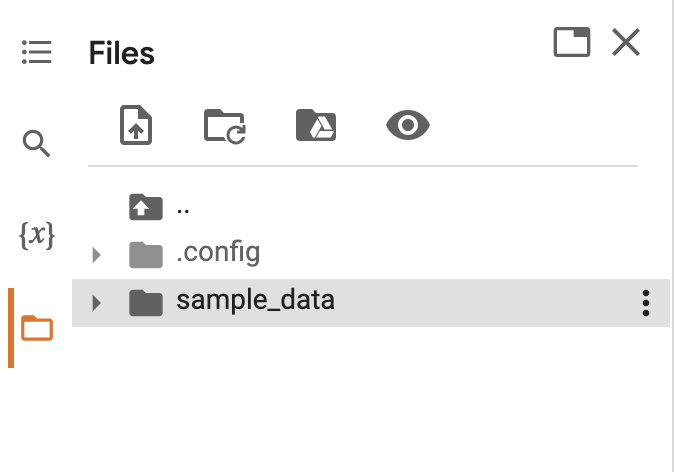 </th>
        <th> 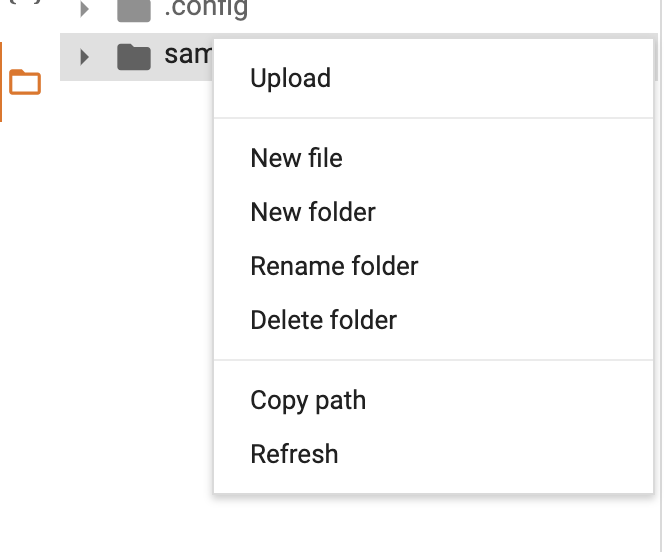 </th>
        <th width="23%"> Add your filepath to the cell which follows. <br>Example: <br><code>file_path = 'content/roadnottaken.txt'</code> </th>
    </tr>
</table>
</center>

In [15]:
## Paste your file path into the empty string('') below
#file_path = '/content/roadnottaken.txt' (example)

file_path = ''

Congratulations! You've finished with the setup! From here, you can now run the rest of the cells to set up your vector store and begin prompting!

# Code Setup
Run the following cells to setup the rest of the environment for prompting. In the following section, we set up the computational environment with imported code, setup your API key access to OpenAI, and loading access to your language model. Note that the following cells may take a long time to run.

## Library installation and loading
The following `pip install` code should be run if you're using Google Colab, or otherwise do not have a computational environment (e.g., _venv_, _conda virtual environment_, _Docker, Singularity, or other container_) with these packages installed.

In [ ]:
# run this code if you're using Google Colab or don't have these packages installed in your computing environment
! pip install -q langchain openai gradio numpy chromadb tiktoken unstructured pdf2image

In [11]:
# import required libraries
import numpy as np
from langchain.text_splitter import CharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
import os
from langchain.vectorstores import Chroma
from langchain.document_loaders.unstructured import UnstructuredFileLoader
from langchain.document_loaders import UnstructuredFileLoader
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI

## API and model setup

Use these cells to load the API keys required for this notebook and create a basic OpenAI LLM model. The code below uses the variable you created above when you input your API Key.

In [12]:
# Set up OpenAI API Key
os.environ["OPENAI_API_KEY"] = openai_api_key

# Create a vector store with your document

With the file path, you can now create a vector store using the document that you uploaded. We expose this creation in case you want to modify the kind of vector store that you're creating. Run the cell below to create the default provided vector store.

In [ ]:
# Create vector store

loader = UnstructuredFileLoader(file_path)
documents = loader.load()

text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
texts = text_splitter.split_documents(documents)

embeddings = OpenAIEmbeddings()

db = Chroma.from_documents(texts, embeddings)

qa = RetrievalQA.from_chain_type(llm=ChatOpenAI(model_name = mdl_name),
                                 chain_type="stuff", retriever=db.as_retriever())

# A guide to prompting for self-study
In this section, we provide a number of different approaches for using AI to help you assess and explain the knowledge of your document. Start by interacting with the model and then try out the rest of the prompts!

## Interact with the model

Now that your vector store is created, you can begin interacting with the model! Below, we have a comprehensive list of examples using different question types, but feel free to use this code block to experiment with the model.

Input your prompt into the empty string in the code cell. See example below:



```
query = 'Your Prompt Here'
```



In [ ]:
# Experiment with interacting with the model by inputting your own prompts into the empty string below.

query = ''
query_prefix = "The uploaded document should serve as the basis for the instructions that follow:"
answer = qa.run(query_prefix + query)
print(answer)

## Types of Questions and Prompts

Below is a comprehensive list of question types and prompt templates designed by our team. There are also example code blocks, where you can see how the model performed with the example and try it for yourself using the prompt template.

### Multiple Choice

Prompt: The following text should be used as the basis for the instructions which follow: {context}. Please design a 5 question quiz about {name or reference to context} which reflects the learning objectives: {list of learning objectives}. The questions should be multiple choice. If I get an answer wrong, provide me with an explanation of why it was incorrect, and then give me additional chances to respond until I get the correct choice. Explain why the correct choice is right.

In [30]:
# Multiple choice code example
query = """Please design a 5 question quiz about Robert Frost's "Road Not Taken" which reflects the learning objectives:
1. Identify the key elements of the poem: narrator, setting, and underlying message.
2. Understand the literary devices used in poetry and their purposes. The questions should be multiple choice.
Provide one question at a time, and wait for my response before providing me with feedback.
If I get an answer wrong, provide me with an explanation of why it was incorrect, and then give me additional
chances to respond until I get the correct choice. Explain why the correct choice is right. """

query_prefix = "The uploaded document should serve as the basis for the instructions that follow:"
answer = qa.run(query_prefix + query)
print(answer)

Great, here's your first question:

1. Who is the narrator in Robert Frost's "The Road Not Taken"?

A) A young boy
B) An old man
C) A traveler
D) None of the above


### Short Answer

Prompt: Please design a 5-question quiz about {context} which reflects the learning objectives: {list of learning objectives}. The questions should be short answer. Expect the correct answers to be {anticipated length} long. If I get any part of the answer wrong, provide me with an explanation of why it was incorrect, and then give me additional chances to respond until I get the correct choice.

In [31]:
# Short answer code example
query = """ Please design a 5-question quiz about Robert Frost's
"Road Not Taken" which reflects the learning objectives:
1. Identify the key elements of the poem: narrator, setting, and underlying message.
2. Understand the literary devices used in poetry and their purposes.
The questions should be short answer. Expect the correct answers to be
1-2 sentences long. Provide one question at a time, and wait for my response before providing me with feedback.
If I get any part of the answer wrong,
provide me with an explanation of why it was incorrect,
and then give me additional chances to respond until I get the correct choice. """

answer = qa.run(query_prefix + query)
print(answer)

Great! Here is the first question:

1. Who is the narrator of "The Road Not Taken"?


### Fill-in-the-blank

Prompt: Create a 5 question fill in the blank quiz refrencing {context}. The quiz should reflect the learning objectives: {learning objectives}. Please prompt me one question at a time and proceed when I answer correctly. If I answer incorrectly, please explain why my answer is incorrect.

In [32]:
# Fill in the blank code example
query = """ Create a 5 question fill in the blank quiz refrencing Robert Frost's "The Road Not Taken."
The quiz should reflect the learning objectives:
1. Identify the key elements of the poem: narrator, setting, and underlying message.
2. Understand the literary devices used in poetry and their purposes.
Please prompt me one question at a time and proceed when I answer correctly.
If I answer incorrectly, please explain why my answer is incorrect. """

answer = qa.run(query_prefix + query)
print(answer)

Great! Here's your first question:

1. Who is the author of "The Road Not Taken"?

Please fill in the blank with the correct answer.


### Sequencing

Prompt: Please develop a 5 question questionnaire that will ask me to recall the steps involved in the following learning objectives in regard to {context}: {learning objectives}. After I respond, explain their sequence to me.

In [33]:
# Sequence example
query = """ Please develop a 5 question questionnaire that will ask me to recall the steps involved in the following learning objectives in regard to Robert Frost's "The Road Not Taken":
1. Identify the key elements of the poem: narrator, setting, and underlying message.
2. Understand the literary devices used in poetry and their purposes.
Provide one question at a time, and wait for my response before providing me with feedback.
After I respond, explain their sequence to me."""

answer = qa.run(query_prefix + query)
print(answer)

Great! Here's your first question:

1. What are the three key elements of Robert Frost's poem "The Road Not Taken"?

Please answer and I will provide the next question.


### Relationships/drawing connections

Prompt: Please design a 5 question quiz that asks me to explain the relationships that exist within the following learning objectives, referencing {context}: {learning objectives}.

In [34]:
# Relationships example
query = """ Please design a 5 question quiz that asks me to explain the relationships that exist within the following learning objectives, referencing Robert Frost's "The Road Not Taken":
1. Identify the key elements of the poem: narrator, setting, and underlying message.
2. Understand the literary devices used in poetry and their purposes.
Provide one question at a time, and wait for my response before providing me with feedback."""

answer = qa.run(query_prefix + query)
print(answer)

Great! Here's your first question: 

1. What are the three key elements of "The Road Not Taken" that you should identify?


### Concepts and Definitions

Prompt: Design a 5 question quiz that asks me about definitions related to the following learning objectives: {learning objectives} - based on {context}".
Once I write out my response, provide me with your own response, highlighting why my answer is correct or incorrect.

In [35]:
# Concepts and definitions example
query = """ Design a 5 question quiz that asks me about definitions related to the following learning objectives:
1. Identify the key elements of the poem: narrator, setting, and underlying message, and
2. Understand the literary devices used in poetry and their purposes - based on Robert Frost's "The Road Not Taken".
Provide one question at a time, and wait for my response before providing me with feedback.
Once I write out my response, provide me with your own response, highlighting why my answer is correct or incorrect."""

answer = qa.run(query_prefix + query)
print(answer)

Great, here's your first question: 

1. Who is the narrator of Robert Frost's poem "The Road Not Taken"? 

Take your time and let me know your answer.


### Real Word Examples

Prompt: Demonstrate how {context} can be applied to solve a real-world problem related to the following learning objectives: {learning objectives}. Ask me questions regarding this theory/concept.

In [36]:
# Real word example
query = """ Demonstrate how Robert Frost’s “The Road Not Taken” can be applied to solve a real-world problem related to the following learning objectives:
1. Identify the key elements of the poem: narrator, setting, and underlying message.
2. Understand the literary devices used in poetry and their purposes.
Ask me questions regarding this theory/concept. Provide one question at a time, and wait for my response before providing me with feedback."""

answer = qa.run(query_prefix + query)
print(answer)

What are the key elements of Robert Frost's poem "The Road Not Taken"?


### Randomized Question Types

Prompt: Please generate a high-quality assessment consisting of 5 varying questions, each of different types (open-ended, multiple choice, etc.), to determine if I achieved the following learning objectives in regards to {context}: {learning objectives}. If I answer incorrectly for any of the questions, please explain why my answer is incorrect.

In [40]:
# Randomized question types
query = """ Please generate a high-quality assessment consisting of 5 varying questions,
each of different types (open-ended, multiple choice, etc.),
to determine if I achieved the following learning objectives in regards to Robert Frost’s “The Road not Taken":
1. Identify the key elements of the poem: narrator, setting, and underlying message.
2. Understand the literary devices used in poetry and their purposes.
When you provide the 5 questions, only send one at a time, wait for my response, then provide me with feedback.
If I answer incorrectly for any of the questions, please explain why my answer is incorrect."""

answer = qa.run(query_prefix + query)
print(answer)

Question 1 (Open-ended): 
Name the key elements of Frost's poem, "The Road not Taken."


### Quantiative evaluation the correctness of a student's answer

Prompt: (A continuation of the previous chat) Please generate the main points of the student’s answer to the previous question, and evaluate on a scale of 1 to 5 how comprehensive the student’s answer was in relation to the learning objectives, and explain why he or she received this rating, including what was missed in his or her answer if the student’s answer wasn’t complete.


In [ ]:
# qualitative evaluation
qualitative_query = """ Please generate the main points of the student’s answer to the previous question,
 and evaluate on a scale of 1 to 5 how comprehensive the student’s answer was in relation to the learning objectives,
 and explain why he or she received this rating, including what was missed in his or her answer if the student’s answer wasn’t complete."""

# Note that this uses the previous result and query in the context
answer = qa.run(query_prefix + query)
print(answer)